## Programming Exercise 7: K-means Clustering and Principal Component Analysis
#### Author - Rishabh Jain

In [1]:
import warnings,os
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from PIL import Image,ImageFilter
from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;K-means Clustering

#### Problem Statement
In this part of the exercise, we will implement the K-means algorithm and use it for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Implementing K-means
The K-means algorithm is a method to autmatically cluster similar data together. We have a training set $\{x^{(1)}...x^{(m)}\}$ where $x^{(i)}\epsilon R^{n}$. The intution behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines the guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on assignments.
```
# Initialize Centroids
centroids=kMeansInitCentroids(X,K)
for i in range(iter):
    # Cluster assignment step: Assign each data point to the closest centroid. idx(i) corrsponds to c(i),
    # the index of the centroid assigned to example i
    idx=findClosestCentroids(X,centroids)
    
    # Move centroid step: Compute means based on centroid assignments
    centroids=computeMeans(X,idx,K);
```

The inner loop of the algoritm carries two steps:
1. Assigning each training example $x^{(i)}$ to its closest centroid.
2. Recomputing the mean of each centroid using the points assigned to it.
The K-means algorithm will always converge to some final set of means for the centroids.

##### 1.1.1&nbsp;&nbsp;&nbsp;&nbsp;Find closest centroids
In the "Cluster assignment" phase of the K-means algorithm, **the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current position of centroid.**
$$c^{(i)}:=j\text{ that minimizes }||x^{(i)}-\mu||^{2}$$

where $c^{(i)}$ is the index of the centroid that is closes to $x^{(i)}$, $\mu^{(j)}$ is the position of $j^{th}$ centroid.

In [2]:
def findClosestCentroids(X,centroids):
    '''Computes and returns the closest centroid label for the given samples'''
    m,n=X.shape
    # Number of clusters(K)
    K=centroids.shape[0]
    c=np.zeros(m)
    for i in range(m):
        x=X[i,:]
        norm=np.zeros(K)
        for k in range(K):
            norm[k]=np.dot((x-centroids[k,:]),(x-centroids[k,:]).T)
        c[i]=np.argmin(norm)
    return c

##### 1.1.2&nbsp;&nbsp;&nbsp;&nbsp;Computing centroid means
Here, we will calculate the centroid new location based on the examples assigned to that centroid. The cordinates of that centroid is mean of the cordinates of all the samples assigned to it.
$$\mu^{(j)}=\frac{\sum_{i\epsilon c_k}x^{(i)}}{|C_k|}$$

where $C_k$ is the set of examples assigned to that centroid.

In [3]:
def computeCentroids(X,c,K):
    '''Computes and returns the new centroids by computing the means of samples assigned to that centroid'''
    m,n=X.shape
    centroids=np.zeros(shape=(K,n))
    for k in range(K):
        x=X[c==k,:]
        centroids[k,:]=x.mean(axis=0)
    return centroids

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;K-means on example dataset

#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Random Initialization
A good strategy for initializing the centroids is to select a random sample from the training set. Example used above first select the random K centroids, finds and compute the closest centroid for each sample in training set.

In [4]:
def runKMeans(X,K,maxIters,plotProgress=False):
    m,n=X.shape
    # Randomly selecting K centroids from X
    indices=np.random.randint(0,m,K)
    centroids=X[indices,:]
    history={}
    for i in range(1,maxIters+1):
        print(f'ITERATION : {i}',end='\r')
        c=findClosestCentroids(X,centroids)
        history[i]=centroids
        centroids=computeCentroids(X,c,K)
    if plotProgress==True and X.shape[1]==2:
        fig,ax=plt.subplots(figsize=(10,8))
        # Plotting points belonging to same cluster
        for k in range(K):
            x=X[c==k,:]
            sns.scatterplot(x[:,0],x[:,1],ax=ax,legend=False)
        # Plotting centroids history
        for i in range(1,maxIters):
            for k in range(K):
                temp=np.array([history[i][k,:],history[i+1][k,:]])
                sns.lineplot(temp[:,0],temp[:,1],color='black')
                sns.scatterplot(temp[:,0],temp[:,1],color='black',marker='x',s=50)
                if i+1==maxIters:
                    sns.scatterplot([temp[1,0]],[temp[1,1]],color='red',marker='x',s=100)
    return c,centroids

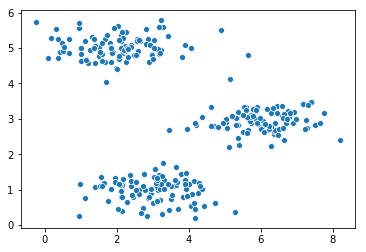

In [5]:
mat=loadmat('ex7data2.mat')
X=mat['X']
sns.scatterplot(X[:,0],X[:,1]);

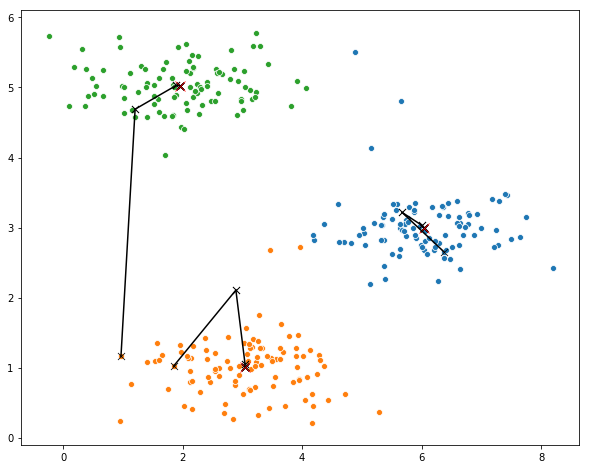

In [6]:
K=3
maxIter=10

labels,centroids=runKMeans(X,K,maxIter,plotProgress=True)

**Note : Red Cross markers are the final centroids of that cluster.**

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;Image compression with K-means

In this example, we will apply K-means for image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as RGB encoding. **Our image contains thousands of colors, and we will reduce the number of colors to 16 colors.**

Concretely, we will treat every pixel in the original image as a part of our dataset and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in 3-dimensional space (RGB).

##### 1.4.1&nbsp;&nbsp;&nbsp;&nbsp;K-means on pixels

On loading the image, we get a 3-D matrix whose first two indices identify a pixel position and whose last index represent a red,green and blue value. Here will reshape the 3-D matrix into mX3 matrix of pixel colors and call our K-means function on it.

**EXAMPLE 1:**

In [7]:
K=16
maxIter=5

img=Image.open('images/bird.png')
mat=np.asarray(img)
print(f'IMAGE DIMENSION : {mat.shape}')
X=mat.reshape((-1,3))
print(f'X SHAPE : {X.shape}')

labels,centroids=runKMeans(X,K,maxIter)
print(f'\n\nTOP {K} COLORS :\n\n',centroids)

IMAGE DIMENSION : (128, 128, 3)
X SHAPE : (16384, 3)
ITERATION : 5

TOP 16 COLORS :

 [[172.60444444 126.36666667  65.58222222]
 [125.36842105 116.31140351 114.3377193 ]
 [100.09865471 119.0044843  172.5426009 ]
 [167.02409639 177.88468158 194.8313253 ]
 [ 28.17068019  29.56991973  27.17384875]
 [139.45366528 100.31258645  43.07607192]
 [ 80.62203024  67.67242621  60.87688985]
 [172.90595611 147.02821317  89.95297806]
 [141.1025641  141.25641026 120.22051282]
 [137.29344729  97.4017094   90.59259259]
 [207.25566811 172.72696575 112.9541727 ]
 [132.22463768 114.95652174  79.63405797]
 [215.83386581 146.66347178  65.47603834]
 [162.42676311 135.36166365 132.39240506]
 [240.20661157 218.8446281  177.30743802]
 [ 91.49846154  92.56       102.30461538]]


After finding the top $K=16$ colors to represent the image, we will now assign each pixel position to its closest centroids. This allows us to represent the original image using centroid assignment of each pixel. We have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each of 128 x 128 pixels, resulting in total of 128 x 128 x 4 = 363,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 128 x 128 X 4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

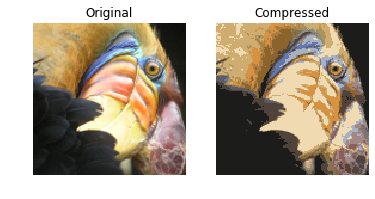

In [8]:
xCompressed=centroids[labels.astype(int),:]
xCompressed=np.uint8(xCompressed.reshape(mat.shape))
fig,ax=plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(Image.fromarray(xCompressed))
ax[1].set_title('Compressed')
ax[1].axis('off');

**EXAMPLE 2:**

In [9]:
K=6
maxIter=10

img=Image.open('images/parrot.png')
mat=np.asarray(img)
print(f'IMAGE DIMENSION : {mat.shape}')
X=mat.reshape((-1,3))
print(f'X SHAPE : {X.shape}')

labels,centroids=runKMeans(X,K,maxIter)
print(f'\n\nTOP {K} COLORS :\n\n',centroids)

IMAGE DIMENSION : (200, 200, 3)
X SHAPE : (40000, 3)
ITERATION : 10

TOP 6 COLORS :

 [[235.7325899  202.56873009   3.26627219]
 [159.38285214  95.66439195   3.95135608]
 [ 65.20264164 149.53041363  61.95933264]
 [  7.49828243 134.48491319 155.27295516]
 [ 23.77816397  40.18217134  36.74667757]
 [217.53982301 223.15124698 210.7071601 ]]


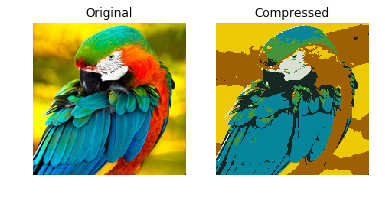

In [10]:
xCompressed=centroids[labels.astype(int),:]
xCompressed=np.uint8(xCompressed.reshape(mat.shape))
fig,ax=plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(Image.fromarray(xCompressed))
ax[1].set_title('Compressed')
ax[1].axis('off');

### 2&nbsp;&nbsp;&nbsp;&nbsp;Principal Component Analysis

<img src="images/PCA1.png">

As we can see in figure (A), three axes: L(Length), W(Width) and H(Height) are used to represent the ellipse in 3-D world. So each data point on ellipse can be written as a function of three variables : 
$$Data(i)=f(L(i),W(i),H(i))$$

But, this is not the best way to represent ellipse. We can do the following improvements:  
1. Find the geometric mean of the ellipse, and set it as the coordinate origin.
2. Find the direction along which the ellipse has the longest radius (large variance) and call it as 'Principal Component 1'.
3. Find the another direction perpendicular to the first one and along which the ellipse has the second longest radius and call it 'Principal Component 2'
4. Re-plot the ellipse under the new coordinate system defined by principal component C1 and C2.

In the new coordinate system, data points on ellipse can re-written as a function of two variables:

$$Data(j)=g(C1(j),C2(j))$$

After the coordinate system transformation, we get:
- Fewer variables (lower dimension of variables) in function g as compared to function f.
- No information lost.
>- f$\approx$g
>- The relative geometric positions of all data points remains unchanged.

**That's exactly what PCA do. The term 'Principal Component' denotes new variables we choose to describe our data in lower dimension. All PCA  must satisfy two conditions :**
1. They must be perpendicular (or mathematically orthogonal) to each other.
>- This means that the principal components are NOT linearly correlated with each other.
>- And that's why PCA can reduce the number of variables without losing much information because the variables in raw data are not independent and correlated variables cause redundancy.
2. These principal components are ordered by the variance in the data points along them. So our data must have the largest variance along the axes of compoenent 1.
>- This means the higher order a component have, the more important it is.
>- **Sometimes we sacrifice minor components to further reduce the number of variables. For example: If the first two components contributed 90% of the variance in the data, we might want to focus on them and discard the rest of the components.**

**Useful Resources**
- [Linear Transformation](https://www.youtube.com/watch?v=kYB8IZa5AuE&list=PL0-GT3co4r2y2YErbmuJw2L5tW4Ew2O5B&index=4)
- [Matrix multiplication as composition](https://www.youtube.com/watch?v=XkY2DOUCWMU&list=PL0-GT3co4r2y2YErbmuJw2L5tW4Ew2O5B&index=5)
- [Eigenvectors and eigenvalues](https://www.youtube.com/watch?v=PFDu9oVAE-g&list=PL0-GT3co4r2y2YErbmuJw2L5tW4Ew2O5B&index=14)

#### 2.1&nbsp;&nbsp;&nbsp;&nbsp;Example Dataset
We will start with a 2D dataset which has one direction of large variation and one of smaller variation.

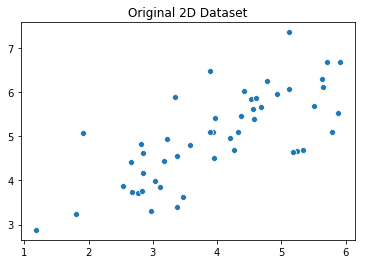

In [11]:
mat=loadmat('./ex7data1.mat')
X=mat['X']
fig=sns.scatterplot(X[:,0],X[:,1]);
fig.set(title='Original 2D Dataset');

#### 2.2&nbsp;&nbsp;&nbsp;&nbsp;Implementing PCA

##### PCA can be implemented in two ways.

1. **EVD (Eigen Value Decomposition)**

>1. First, the values in Data matrix (X of m x n shape) are centered and scaled by subtracting the mean of each features and dividing the resultant by the standard deviation of each feature.
$$X=\frac{X-\bar{X}}{\sigma(X)}$$
>2. Covariance matrix (C of n x n shape) is calculated for the normalized matrix.
```
C=np.cov(X.T)
```
>3. Finally, we calculate the eigen decomposition of the covariance matrix (C). This results in a list of eigenvalues and eigenvectors. The eigenvectors represent the directions or principal components for the reduced subspace of the data matrix whereas the eigenvalues represents the magnitude for the directions.
```
eigenValues,eigenVectors=np.linalg.eig(C)
```
>4. The eigenvectors can be sorted by the eigenvalues in descending order to provide a ranking of the components or axes of the new subspace for data matrix (X).
```
idx=eigenValues.argsort()[::-1]
eigenValues=eigenValues[idx]
eigenVectors=eigenVectors[:idx]
```
>5. A total of m or less components must be selected to comprise the chosen subspace. Ideally, we would select k eigenvectors, called principal components (m x k shape), that have the k largest eigenvalues.
```
principalComponents=eigenVectors[:,:k]
```
>6. Once chosen, data matrix (of shape m X n) can be projected into the subspace (of shape m x k) via matrix multiplication.
```
Z=X.dot(principalComponents)
```

2. **SVD (Singular Value Decomposition)**

>1. First, the values in Data matrix (X of m x n shape) are centered and scaled by subtracting the mean of each features and dividing the resultant by the standard deviation of each feature.
$$X=\frac{X-\bar{X}}{\sigma(X)}$$
>2. Finally, we calculate the singular value decomposition of the normalized matrix (X of shape m x n). This returns the U, Sigma and $V^T$ elements. This U is an m x m matrix, Sigma is a list of singular values and $V^T$ is the transpose of an n x n matrix.
```
U,S,VT=np.linalg.svd(X)
V=VT.T
```
>3. The singular values are sorted in descending order to provide a ranking of the components or axes of the new subspace for data matrix (X).
```
idx=S.argsort()[::-1]
S=S[idx]
V=V[:idx]
```
>4. A total of m or less components must be selected to comprise the chosen subspace. Ideally, we would select k singular vectors, called principal components (m x k shape), that have the k largest eigenvalues.
```
principalComponents=V[:,:k]
```
>5. Once chosen, data matrix (of shape m x n) can be projected into the subspace (of shape m x k) via matrix multiplication.
```
Z=X.dot(principalComponents)
```

Note:
- Eigen vectors from EVD and Singular vectors from SVD are both same.
- SVD is computationally more efficient as $XX^T$ calculation is not required in SVD whereas it is required in EVD.

In [12]:
def featureNormalize(X):
    '''Returns the normalized matrix'''
    mean=np.mean(X,axis=0)
    std=np.std(X,axis=0)
    xNormalized=(X-mean)/std
    return xNormalized

**PCA using EVD**

EIGENVALUES : 
[1.77094936 0.26986696]

EIGENVECTORS : 
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


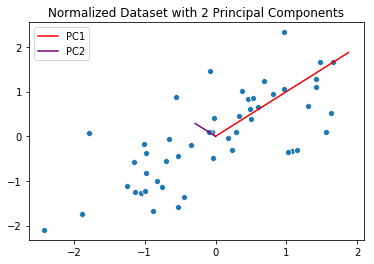

In [13]:
# Normalizing
X=featureNormalize(X)
# Computing covariance
C=np.cov(X.T)
# Computing eigenvectors
eigenValues,eigenVectors=np.linalg.eig(C)
# Sorting eigenvectors based on eigenvalues
idx=eigenValues.argsort()[::-1]
eigenValues=eigenValues[idx]
eigenVectors=eigenVectors[:,idx]

print("EIGENVALUES : ",eigenValues,sep='\n',end='\n\n')
print("EIGENVECTORS : ",eigenVectors,sep='\n')


fig=sns.scatterplot(X[:,0],X[:,1]);
points=list(zip([0,0],1.5*eigenValues[0]*eigenVectors[:,0]))
sns.lineplot(*points,label='PC1',color='red')
points=list(zip([0,0],1.5*eigenValues[1]*eigenVectors[:,1]))
sns.lineplot(*points,label='PC2',color='purple');
fig.set(title='Normalized Dataset with 2 Principal Components');

#### 2.3&nbsp;&nbsp;&nbsp;&nbsp;Dimensionality Reduction with PCA

After computing the principal components, we can use them to reduce the feature dimension of our dataset by projecting each example onto a lower dimensional space $x^{(i)}\rightarrow z^{(i)}$. In this part of the exercise, **we will use the computed eigenvectors and project the example dataset into a 1-dimensional space.**   
In practice, if we were using a learning algorithm such as linear regression or prehaps Nerual network, we could now use the  projected data instead of the original data as there are less dimensions in the input.

##### 2.3.1&nbsp;&nbsp;&nbsp;&nbsp;Projecting the data onto the principal components

(50, 1)


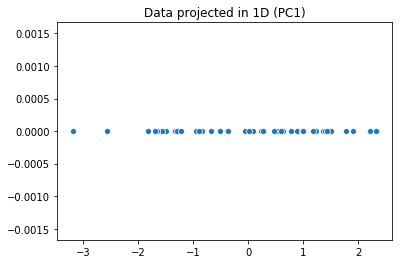

In [14]:
# Selecting top k principal components from eigenvectors matrix
k=1
principalComponents=eigenVectors[:,:k]
# Projecting the centered data matrix using only the top K eigenvectors
Z=X.dot(principalComponents)
print(Z.shape)
fig=sns.scatterplot(Z.reshape(-1),0);
fig.set(title='Data projected in 1D (PC1)');

##### 2.3.2&nbsp;&nbsp;&nbsp;&nbsp;Reconstructing an approximation of the data
After projecting the data onto the lower dimensional space, we can approximately recover the data by projecting them back onto the original high dimensional space.

In [15]:
xRec=Z.dot(principalComponents.T)
print(xRec.shape)
xRec[:5]

(50, 2)


array([[-1.05805279, -1.05805279],
       [ 0.65208021,  0.65208021],
       [-0.86577611, -0.86577611],
       [-1.16238578, -1.16238578],
       [-0.90030292, -0.90030292]])

##### 2.3.3&nbsp;&nbsp;&nbsp;&nbsp;Visualizing the projections
 Here we will plot the projection and the approximate reconstruction to show how the projection affects the data.

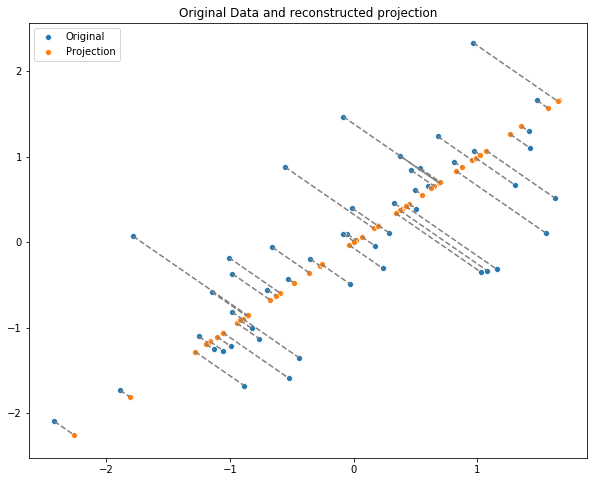

In [16]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
sns.scatterplot(X[:,0],X[:,1],label='Original');
sns.scatterplot(xRec[:,0],xRec[:,1],label='Projection');
for i in range(X.shape[0]):
    points=list(zip(X[i,:],xRec[i,:]))
    sns.lineplot(*points,color='gray')
    ax.lines[i].set_linestyle('--')
ax.set(title='Original Data and reconstructed projection');

The reconstructed projection effectively only retains the information in the direction given by PC1.

#### 2.4&nbsp;&nbsp;&nbsp;&nbsp;Face Image Dataset

In this part of the exercise, we will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset contains 5000 grayscale face images of 32 X 32 pixel size.

In [17]:
mat=loadmat('./ex7faces.mat')
print(*mat.keys(),sep='\n')

# Loading data from mat to Dataframe
X=mat['X']
m,n=X.shape

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=X[:,i]

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data.sample(5)

__header__
__version__
__globals__
X
TRAINING DATASET SHAPE : 5000 X 1024


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1015,x1016,x1017,x1018,x1019,x1020,x1021,x1022,x1023,x1024
3051,54.133686,53.133686,54.133686,54.133686,44.133686,34.133686,21.133686,7.133686,11.133686,40.133686,...,-55.866314,-79.866314,-93.866314,-99.866314,-102.866314,-100.866314,-98.866314,-96.866314,-97.866314,-97.866314
198,-3.866314,-6.866314,-10.866314,-7.866314,-6.866314,-9.866314,-11.866314,-23.866314,-28.866314,-10.866314,...,-14.866314,-21.866314,-30.866314,-32.866314,-34.866314,-27.866314,-19.866314,-23.866314,-23.866314,-37.866314
4207,-0.866314,5.133686,9.133686,12.133686,5.133686,-2.866314,-5.866314,-4.866314,0.133686,1.133686,...,22.133686,49.133686,38.133686,-7.866314,-51.866314,-68.866314,-76.866314,-80.866314,-72.866314,-90.866314
4399,4.133686,4.133686,5.133686,9.133686,12.133686,12.133686,11.133686,15.133686,14.133686,10.133686,...,-58.866314,-60.866314,-69.866314,-79.866314,-81.866314,-70.866314,-65.866314,-78.866314,-97.866314,-110.866314
1976,35.133686,38.133686,41.133686,44.133686,46.133686,48.133686,44.133686,40.133686,43.133686,43.133686,...,-121.866314,-121.866314,-121.866314,-121.866314,-122.866314,-120.866314,-119.866314,-102.866314,5.133686,61.133686


**Visualizing data**

In [18]:
def displayData(X,title=None):
    m,n=X.shape
    width=int(np.sqrt(n))
    height=int(n/width)
    rows=int(np.floor(np.sqrt(m)))
    cols=int(np.ceil(m/rows))
    totalWidth=cols+cols*width
    displayArray=np.zeros((1,totalWidth))
    rowPadding=np.ones((1,totalWidth))*np.min(X)
    colPadding=np.ones((height,1))*np.min(X)
    index=0
    for i in range(rows):
        row=colPadding*0
        for j in range(cols):
            if index<m:
                x=X[index].reshape((width,height)).T
                index=index+1
            else:
                x=np.zeros((width,height)).T
            row=np.column_stack((row,x))
            if j<cols-1:
                row=np.column_stack((row,colPadding))
        displayArray=np.row_stack((displayArray,row))
        if i<rows-1:
            displayArray=np.row_stack((displayArray,rowPadding))
    displayArray=np.row_stack((displayArray,rowPadding*0))
    plt.imshow(displayArray,cmap='gray')
    plt.title(title)
    plt.axis('off')

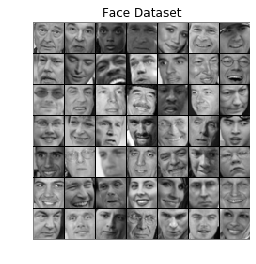

In [19]:
randomIndices=np.random.randint(0,X.shape[0],49)
displayData(X[randomIndices,:],'Face Dataset');

**Before running PCA, let's take a look at mean of all human faces.**

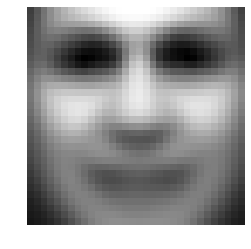

In [20]:
plt.imshow(X.mean(axis=0).reshape((32,32)).T,cmap='gray')
plt.axis('off');

##### 2.4.1&nbsp;&nbsp;&nbsp;&nbsp;PCA on Faces

To run PCA on faces, we will first normalize the dataset. After running PCA, we will obtain the principal components of the dataset. Notice that each principal component in VT is of length n=1024. It

In [21]:
# Normalizing
X=featureNormalize(X)
# SVD
U,S,VT=np.linalg.svd(X)
V=VT.T
# Sorting singular vector based on singular values
idx=S.argsort()[::-1]
S=S[idx]
V=V[:,idx]

print(f'U : {U.shape}')
print(f'S : {S.shape}')
print(f'V : {V.shape}')

U : (5000, 5000)
S : (1024,)
V : (1024, 1024)


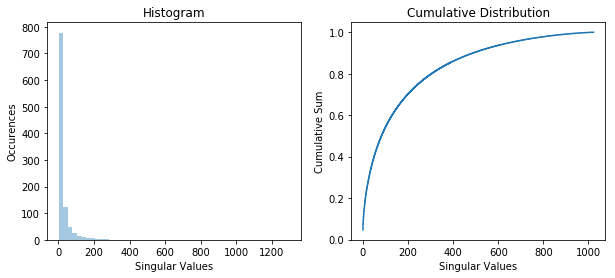

In [22]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,4))
chart1=sns.distplot(S,kde=False,ax=ax[0]);
chart1.set(xlabel='Singular Values',ylabel='Occurences',title='Histogram')
s=S/np.sum(S)
chart2=sns.lineplot(list(range(len(s))),np.cumsum(s),drawstyle='steps',ax=ax[1])
chart2.set(xlabel='Singular Values',ylabel='Cumulative Sum',title='Cumulative Distribution');

From the above graph, we can conclude few things:
1. There are a lot of singular values that seems to matter for this dataset.
2. In order to get 95% variance of the data, we will end up selecting almost 800 out of 1024 singular values or principal components which are majority of them.
3. This data is very noisy and has a lot of variability which can only be explained by a dataset with relatively larger dimension.

Let's take a look at the first 36 principal components that describe the largest variations.

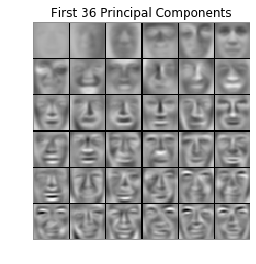

In [23]:
k=36
principalComponents=V[:,:k]
displayData(principalComponents.T,f'First {k} Principal Components');

##### 2.4.2&nbsp;&nbsp;&nbsp;&nbsp;Dimensionality Reduction

Now that we have computed the principal components for the face dataset, we can use it to reduce the dimension of the face dataset. This allows us to use our learning algorithm with a smaller input size (e.g. 100 dimensions) instead of the original 1024 dimensions. This can help speed our learning algorithm.

In [24]:
# Selecting top k principal components from singular vector matrix
k=100
principalComponents=V[:,:k]
# Projecting the centered data matrix using only the top K singular vectors
Z=X.dot(principalComponents)
Z.shape

(5000, 100)

Reconstructing data matrix with original dimension from the lower dimension.

In [25]:
xRec=Z.dot(principalComponents.T)
print(xRec.shape)

(5000, 1024)


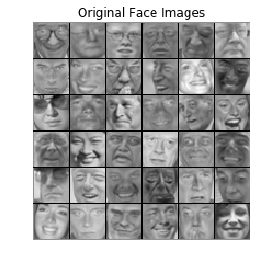

In [26]:
displayData(X[:36],'Original Face Images');

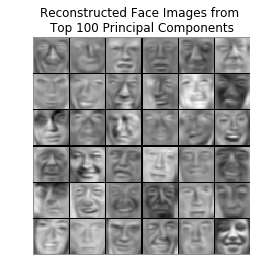

In [27]:
displayData(xRec[:36],f'Reconstructed Face Images from \nTop {k} Principal Components')

From the reconstrution, we can observe that the genral structure and appearence of the face are kept while the fine details are lost. This is a remarkable reduction (more than 10x) in the dataset size that can help us speed our learning algorithm significantly. For example, if we were training a neural network to perform person recognition, we can use the dimension reduced input of only a 100 dimensions instead of the original dataset.

<img src="https://i.imgflip.com/20b7sy.jpg" width="300">